In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from numba import njit, float64, int64
from numba.types import Tuple
from multiprocessing import Pool, cpu_count
from verlet_cython import velocity_verlet_cython

In [2]:
G = 6.67430e-11

In [3]:
def initialize_particles(N):
    masses = np.random.rand(N) * 1e20
    positions = np.random.rand(N, 2) * 1e11
    velocities = np.random.rand(N, 2) * 1e3
    return masses, positions, velocities

In [4]:
def velocity_verlet(masses, positions, velocities, dt, steps):
    N = len(masses)
    traj = np.zeros((N, 2, steps))
    traj[:, :, 0] = positions
    pos = positions.copy()
    vel = velocities.copy()

    def compute_acc(pos):
        acc = np.zeros_like(pos)
        for i in range(N):
            for j in range(N):
                if i != j:
                    r = pos[j] - pos[i]
                    dist = np.linalg.norm(r) + 1e-10
                    acc[i] += G * masses[j] * r / dist**3
        return acc

    acc = compute_acc(pos)
    for t in range(1, steps):
        pos += vel * dt + 0.5 * acc * dt**2
        new_acc = compute_acc(pos)
        vel += 0.5 * (acc + new_acc) * dt
        acc = new_acc
        traj[:, :, t] = pos
    return traj

In [5]:
@njit(float64[:, :, :](float64[:], float64[:, :], float64[:, :], float64, int64))
def velocity_verlet_numba(masses, positions, velocities, dt, steps):
    N = masses.shape[0]
    traj = np.zeros((N, 2, steps), dtype=np.float64)
    traj[:, :, 0] = positions
    pos = positions.copy()
    vel = velocities.copy()
    acc = np.zeros((N, 2), dtype=np.float64)

    for i in range(N):
        for j in range(N):
            if i != j:
                r = positions[j] - positions[i]
                dist = np.sqrt(r[0]**2 + r[1]**2) + 1e-10
                acc[i, 0] += G * masses[j] * r[0] / dist**3
                acc[i, 1] += G * masses[j] * r[1] / dist**3

    for t in range(1, steps):
        pos += vel * dt + 0.5 * acc * dt**2
        new_acc = np.zeros((N, 2), dtype=np.float64)
        for i in range(N):
            for j in range(N):
                if i != j:
                    r = pos[j] - pos[i]
                    dist = np.sqrt(r[0]**2 + r[1]**2) + 1e-10
                    new_acc[i, 0] += G * masses[j] * r[0] / dist**3
                    new_acc[i, 1] += G * masses[j] * r[1] / dist**3
        vel += 0.5 * (acc + new_acc) * dt
        acc = new_acc
        traj[:, :, t] = pos

    return traj

In [6]:
def compute_acceleration_parallel(args):
    i, pos, masses = args
    N = len(masses)
    acc_i = np.zeros(2)
    for j in range(N):
        if i != j:
            r = pos[j] - pos[i]
            dist = np.linalg.norm(r) + 1e-10
            acc_i += G * masses[j] * r / dist**3
    return i, acc_i

def compute_acc_parallel(pos, masses, pool):
    N = len(masses)
    results = pool.map(compute_acceleration_parallel, [(i, pos, masses) for i in range(N)])
    acc = np.zeros_like(pos)
    for i, acc_i in results:
        acc[i] = acc_i
    return acc

def velocity_verlet_parallel(masses, positions, velocities, dt, steps, pool):
    N = len(masses)
    traj = np.zeros((N, 2, steps))
    traj[:, :, 0] = positions
    pos = positions.copy()
    vel = velocities.copy()

    acc = compute_acc_parallel(pos, masses, pool)
    for t in range(1, steps):
        pos += vel * dt + 0.5 * acc * dt**2
        new_acc = compute_acc_parallel(pos, masses, pool)
        vel += 0.5 * (acc + new_acc) * dt
        acc = new_acc
        traj[:, :, t] = pos
    return traj

In [7]:
def run_benchmark(N, steps=500, dt=0.01):
    print('Current N = ' + str(N))
    masses, positions, velocities = initialize_particles(N)
    
    print('verle')
    t0 = time()
    velocity_verlet(masses, positions, velocities, dt, steps)
    sequential_time = time() - t0

    print('verle + numba')
    t0 = time()
    velocity_verlet_numba(masses, positions, velocities, dt, steps)
    numba_time = time() - t0
    
    print('verle + multi')
    t0 = time()
    #with Pool(processes=cpu_count()) as pool:
        #velocity_verlet_parallel(masses, positions, velocities, dt, steps, pool)
    #velocity_verlet_parallel(masses, positions, velocities, dt, steps)
    parallel_time = time() - t0
    
    print('verle + cython')
    t0 = time()
    velocity_verlet_cython(masses, positions, velocities, dt, steps)
    cython_time = time() - t0

    return sequential_time, numba_time, parallel_time, cython_time

In [11]:
def plot_benchmarks():
    N_values = np.array([100, 200, 400])
    sequential_times = np.zeros(3)
    numba_times = np.zeros(3)
    parallel_times = np.zeros(3)
    cython_times = np.zeros(3)
    
    ind = 0

    for N in N_values:
        sequential_time1, numba_time1, parallel_time1, cython_time1 = run_benchmark(N)
        sequential_time2, numba_time2, parallel_time2, cython_time2 = run_benchmark(N)
        sequential_time3, numba_time3, parallel_time3, cython_time3 = run_benchmark(N)
        
        sequential_time = (sequential_time1 + sequential_time2 + sequential_time3) / 3
        numba_time = (numba_time1 + numba_time2 + numba_time3) / 3
        parallel_time = (parallel_time1 + parallel_time2 + parallel_time3) / 3
        cython_time = (cython_time1 + cython_time2 + cython_time3) / 3
        
        sequential_times[ind] = sequential_time
        numba_times[ind] = numba_time
        parallel_times[ind] = parallel_time
        cython_times[ind] = cython_time
        
        ind += 1
        
    parallel_times = np.array([6.023835817972819, 20.049667437871296, 69.23185578982036])
    opencl_times = np.array([0.9291419982910156, 0.9740900993347168, 0.9830666383107504])

    plt.figure(figsize=(10, 5))
    plt.plot(N_values, sequential_times, label='Верле (последовательный)', marker='o')
    plt.plot(N_values, numba_times, label='Верле + Numba', marker='o')
    plt.plot(N_values, parallel_times, label='Верле + multiprocessing', marker='o')
    plt.plot(N_values, cython_times, label='Верле + cython', marker='o')
    plt.plot(N_values, opencl_times, label='Верле + opencl', marker='o')
    plt.title('Время работы методов Верле при разных N')
    plt.xlabel('Количество частиц (N)')
    plt.ylabel('Время работы (с)')
    plt.legend()
    plt.grid()
    plt.show()
    
    return sequential_times, numba_times, parallel_times, cython_times, opencl_times

In [12]:
def plot_speedup(sequential_times, numba_times, parallel_times, cython_times, opencl_times):
    N_values = [100, 200, 400]

    speedup_numba = sequential_times / numba_times
    speedup_parallel = sequential_times / parallel_times
    speedup_cython = sequential_times / cython_times
    speedup_opencl = sequential_times / opencl_times

    plt.figure(figsize=(10, 5))
    plt.plot(N_values, speedup_numba, label='Ускорение (Numba)', marker='o')
    plt.plot(N_values, speedup_parallel, label='Ускорение (multiprocessing)', marker='o')
    plt.plot(N_values, speedup_cython, label='Ускорение (cython)', marker='o')
    plt.plot(N_values, speedup_opencl, label='Ускорение (opencl)', marker='o')
    plt.title('Ускорение методов Верле по сравнению с оригинальным методом')
    plt.xlabel('Количество частиц (N)')
    plt.ylabel('Ускорение')
    plt.legend()
    plt.grid()
    plt.show()

Current N = 100
verle
verle + numba
verle + multi
verle + cython
Current N = 100
verle
verle + numba
verle + multi
verle + cython
Current N = 100
verle
verle + numba
verle + multi
verle + cython
Current N = 200
verle
verle + numba
verle + multi
verle + cython
Current N = 200
verle
verle + numba
verle + multi
verle + cython
Current N = 200
verle
verle + numba
verle + multi
verle + cython
Current N = 400
verle
verle + numba
verle + multi
verle + cython
Current N = 400
verle
verle + numba
verle + multi
verle + cython
Current N = 400
verle
verle + numba
verle + multi
verle + cython


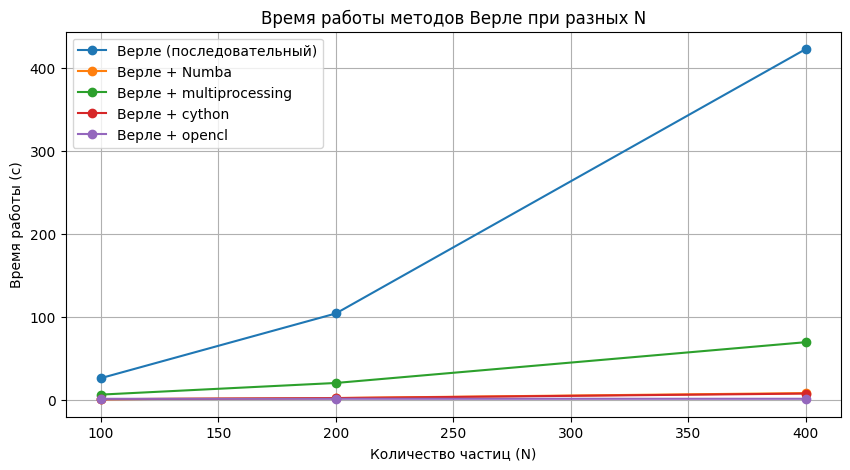

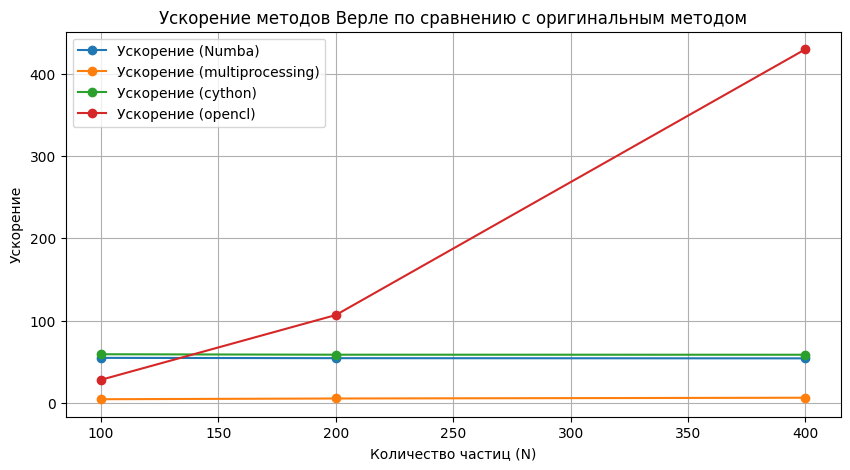

In [13]:
def main():
    sequential_time, numba_time, parallel_time, cython_time, opencl_time = plot_benchmarks()
    plot_speedup(sequential_time, numba_time, parallel_time, cython_time, opencl_time)


if __name__ == "__main__":
    main()